# Regression Engine to predict Arrival Delay

In [37]:
# Pre-requisites
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Store the classifier models to save time
import joblib

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Classifiers from scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Performance metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# Path to your file within Google Drive
file_path = '/content/drive/MyDrive/PFE/flights.csv'

# Read the file using pandas
df = pd.read_csv(file_path)
df.dropna(inplace=True)

In [25]:
df.head()

,aircraft,date,from,to,flight,flight_time,scheduled_time_departure,actual_time_departure,scheduled_time_arrival,status,actual_time_arrival,from_city,to_city,rounded_hour,airport,delay_time
0,se-rrb,2024-03-20,arn,szg,D84471,2024-03-20T01:50:00.000+01:00,2024-03-20T10:15:00.000+01:00,2024-03-20T10:28:00.000+01:00,2024-03-20T12:25:00.000+01:00,On Time,2024-03-20T12:18:00.000+01:00,stockholm,salzburg,2024-03-20T12:00:00.000+01:00,szg,-7.0
1,se-rrb,2024-03-03,ume,arn,D84014,2024-03-03T00:50:00.000+01:00,2024-03-03T17:45:00.000+01:00,2024-03-03T17:54:00.000+01:00,2024-03-03T18:50:00.000+01:00,On Time,2024-03-03T18:44:00.000+01:00,umea,stockholm,2024-03-03T19:00:00.000+01:00,arn,-6.0
2,se-rrb,2023-12-03,arn,lla,D84039,2023-12-03T01:07:00.000+01:00,2023-12-03T13:05:00.000+01:00,2023-12-03T13:18:00.000+01:00,2023-12-03T14:25:00.000+01:00,On Time,2023-12-03T14:24:00.000+01:00,stockholm,lulea,2023-12-03T14:00:00.000+01:00,lla,-1.0
3,se-rrb,2023-12-03,lla,arn,D84036,2023-12-03T01:04:00.000+01:00,2023-12-03T10:15:00.000+01:00,2023-12-03T10:31:00.000+01:00,2023-12-03T11:35:00.000+01:00,On Time,2023-12-03T11:35:00.000+01:00,lulea,stockholm,2023-12-03T12:00:00.000+01:00,arn,0.0
4,se-rrb,2023-08-11,pmi,arn,D84214,2023-08-11T03:13:00.000+01:00,2023-08-11T20:05:00.000+01:00,2023-08-11T20:05:00.000+01:00,2023-08-11T23:45:00.000+01:00,On Time,2023-08-11T23:18:00.000+01:00,palma de mallorca,stockholm,2023-08-11T00:00:00.000+01:00,arn,-27.0


In [26]:
df['status'] = df['status'].map({"On Time": 0, "Delayed": 1})

# Convert datetime string column to datetime type
df['flight_time'] = pd.to_datetime(df['flight_time']).dt.tz_localize(None)
df['scheduled_time_departure'] = pd.to_datetime(df['scheduled_time_departure']).dt.tz_localize(None)
df['actual_time_departure'] = pd.to_datetime(df['actual_time_departure']).dt.tz_localize(None)
df['scheduled_time_arrival'] = pd.to_datetime(df['scheduled_time_arrival']).dt.tz_localize(None)
df['actual_time_arrival'] = pd.to_datetime(df['actual_time_arrival']).dt.tz_localize(None)
df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
df["status"] = df["status"].astype('int')

df["departure_delay"] = df["actual_time_departure"] - df["scheduled_time_departure"]
# Convert the departure delay to minutes
df['departure_delay'] = df['departure_delay'].dt.total_seconds() / 60

df["departure_delay_15"] = df["departure_delay"] > 15
df["departure_delay_15"] = df["departure_delay_15"].astype('int')

df = df[df['status']==1]



df["arrival_delay"] = df["actual_time_arrival"] - df["scheduled_time_arrival"]
# Convert the arrival delay to minutes
df['arrival_delay'] = df['arrival_delay'].dt.total_seconds() / 60


df['year'] = df['scheduled_time_arrival'].dt.year
df['month'] = df['scheduled_time_arrival'].dt.month
df['day'] = df['scheduled_time_arrival'].dt.day
df['hour'] = df['scheduled_time_arrival'].dt.hour
df['dayofweek'] = df['scheduled_time_arrival'].dt.dayofweek
df['quarter'] = df['scheduled_time_arrival'].dt.quarter
df['is_year_start'] = df['scheduled_time_arrival'].dt.is_year_start
df['is_year_end'] = df['scheduled_time_arrival'].dt.is_year_end

df["is_year_start"] = df["is_year_start"].astype('int')
df["is_year_end"] = df["is_year_end"].astype('int')

cols = ['flight', 'aircraft', 'from', 'to', 'from_city',
       'to_city', 'year', 'month', 'day', 'hour', 'dayofweek', 'quarter', 'is_year_start', 'is_year_end', 'departure_delay', 'arrival_delay' ]

df = df[cols]

<ipython-input-26-30608d339423>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["arrival_delay"] = df["actual_time_arrival"] - df["scheduled_time_arrival"]
<ipython-input-26-30608d339423>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['arrival_delay'] = df['arrival_delay'].dt.total_seconds() / 60
<ipython-input-26-30608d339423>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [27]:
# encode categorical data into numeric values
labelEncoder = LabelEncoder()
df["flight"] = labelEncoder.fit_transform(df["flight"])
df["aircraft"] = labelEncoder.fit_transform(df["aircraft"])
df["from"] = labelEncoder.fit_transform(df["from"])
df["to"] = labelEncoder.fit_transform(df["to"])
df["from_city"] = labelEncoder.fit_transform(df["from_city"])
df["to_city"] = labelEncoder.fit_transform(df["to_city"])

<ipython-input-27-2d203ca30ee5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["flight"] = labelEncoder.fit_transform(df["flight"])
<ipython-input-27-2d203ca30ee5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["aircraft"] = labelEncoder.fit_transform(df["aircraft"])


In [28]:
# Show the first few rows of the DataFrame
pd.set_option('display.max_columns', None)
df.head()

,flight,aircraft,from,to,from_city,to_city,year,month,day,hour,dayofweek,quarter,is_year_start,is_year_end,departure_delay,arrival_delay
20,5388,118,889,179,821,188,2023,4,11,22,1,2,0,0,36.0,17.0
23,6342,191,814,1284,805,1219,2023,12,27,21,2,4,0,0,58.0,33.0
48,22650,313,72,199,1317,214,2023,11,1,18,2,4,0,0,41.0,25.0
50,22669,313,1141,72,1049,1320,2023,9,13,15,2,3,0,0,72.0,46.0
51,22873,313,243,72,1058,1320,2023,6,6,21,1,2,0,0,128.0,107.0


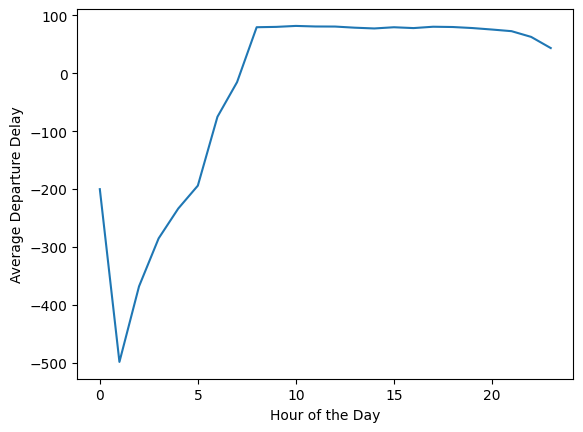

In [29]:
# @title Departure Delay vs Hour of the Day

import matplotlib.pyplot as plt
df.groupby('hour')['departure_delay'].mean().plot(kind='line')
plt.xlabel('Hour of the Day')
_ = plt.ylabel('Average Departure Delay')

In [31]:
X = df.loc[:, df.columns != "arrival_delay"]
y = np.array(df.loc[:, df.columns == "arrival_delay"]["arrival_delay"])

In [32]:
print(f"\nDataset shape: {df.shape}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(f"features_train shape: {X_train.shape} | features_test shape: {X_test.shape}")
print(f"labels_train shape: {y_train.shape} | labels_test shape: {y_test.shape}")


Dataset shape: (70970, 16)
features_train shape: (56776, 15) | features_test shape: (14194, 15)
labels_train shape: (56776,) | labels_test shape: (14194,)


In [43]:
def print_metrics(labels_test, model_pred, regressor_name):

    mse = mean_squared_error(labels_test, model_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels_test, model_pred)
    r2 = r2_score(labels_test, model_pred)

    print(f"MSE      : {mse}", end="\n\n")
    print(f"RMSE     : {rmse}", end="\n\n")
    print(f"MAE      : {mae}", end="\n\n")
    print(f"R2 Score : {r2}", end="\n\n")

##Linear Regression

In [35]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [44]:
model_pred = model.predict(X_test)
print_metrics(y_test, model_pred, "LinearRegression")

MSE      : 39197.679452524135

RMSE     : 197.9840383781585

MAE      : 101.52480181911845

R2 Score : 0.18429439114199897



## Decision Tree Regressor

In [45]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [46]:
model_pred = model.predict(X_test)
print_metrics(y_test, model_pred, "DecisionTreeRegressor")

MSE      : 8135.350782020572

RMSE     : 90.196179420309

MAE      : 17.796745103564888

R2 Score : 0.830702956001285



## XGBoost

In [47]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [48]:
model_pred = model.predict(X_test)
print_metrics(y_test, model_pred, "GradientBoostingRegressor")

MSE      : 5301.3460466482675

RMSE     : 72.81034299224436

MAE      : 16.443151039499398

R2 Score : 0.8896787318752943



## Random Forest

In [49]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [50]:
model_pred = model.predict(X_test)
print_metrics(y_test, model_pred, "RandomForestRegressor")

MSE      : 4648.347743548015

RMSE     : 68.17879247645865

MAE      : 14.58024518575924

R2 Score : 0.903267658205966



## Extra Trees Regressor

In [51]:
model = ExtraTreesRegressor()
model.fit(X_train, y_train)

ExtraTreesRegressor()

In [52]:
model_pred = model.predict(X_test)
print_metrics(y_test, model_pred, "ExtraTreesRegressor")

MSE      : 4650.68890418839

RMSE     : 68.19595958844182

MAE      : 15.981311821896576

R2 Score : 0.9032189385395912



# => Random forest is the best regressor